# Imports

In [1]:
import pandas as pd
import numpy as np
import ast
from datetime import datetime

# Helper functions

In [2]:
conversion_rates = {
    'CHF': 1.14,  # 1 CHF = 1.134556 USD as of Feb 20, 2024, according to X-Rates
    'TRY': 0.032,   # 1 TRY = 0.03230 USD as of Feb 21, 2024, according to Wise
    'PLN': 0.25,  # 1 PLN = 0.250338 USD as of Feb 21, 2024, according to Xe.com
    'GBP': 1.26,      # Example rate, adjust with the actual rate when available
    'JOD': 1.41,      # Example rate, adjust with the actual rate when available
    'AUD' : 0.66,
    'BRL' : 0.2,
    'IDR' : 0.000064,
    'USD' : 1.0,
    'EUR' : 1.08,
    'ALL' : 0.010,
    'JPY' : 0.0066,
    'BDT' : 0.0091,

}



In [3]:
def convert_to_usd(row, price_col_name, currency_col_name):
    price = row[price_col_name]
    currency = row[currency_col_name]
    price = row['ticket_price']
    conversion_rate = conversion_rates.get(currency)

    # Check if conversion_rate is None
    if conversion_rate is None:
        # Handle the error (e.g., return 0, raise an exception, or use a default conversion rate)
        raise ValueError(f"Conversion rate for currency '{currency}' is not available.")
        # Alternatively, you can return 0 or some default value instead of raising an error
        # return 0
    
    return price * conversion_rate


In [4]:
def clean_fifth_element(lst):
    cleaned_lst = []
    for item in lst:
        if len(item) >= 5:
            fifth_element = item[4]
            if isinstance(fifth_element, int):
                cleaned_lst.append(fifth_element)
            else:
                try:
                    cleaned_lst.append(int(fifth_element))
                except ValueError:
                    # If the fifth element cannot be converted to an integer, replace it with 0
                    cleaned_lst.append(0)
        else:
            cleaned_lst.append(0)  # If the list is too short, consider the fifth element as 0
    return cleaned_lst



In [5]:
def convert_list_to_datetime(date_list):
    # Convert 'null' strings to 0 and other elements to integers
    date_list = [0 if element == 'null' else int(element) for element in date_list]
    
    try:
        if len(date_list) == 5:
            # If all components are present, unpack the list directly into datetime
            return datetime(*date_list)
        elif len(date_list) == 4:
            # If the minute is missing (or any single component), append 0 for minutes and then convert
            return datetime(*(date_list + [0]))
        else:
            # Return None for lists of unexpected length to indicate an issue
            return None
    except TypeError:
        # Handle cases where the list contents cannot be directly unpacked into datetime
        return None




In [6]:
def clean_fifth_element(lst):
    cleaned_lst = []
    for item in lst:
        if len(item) >= 5:
            fifth_element = item[4]
            if isinstance(fifth_element, int):
                cleaned_lst.append(item[:4] + [fifth_element] + item[5:])
            else:
                try:
                    cleaned_lst.append(item[:4] + [int(fifth_element)] + item[5:])
                except ValueError:
                    # If the fifth element cannot be converted to an integer, replace it with 0
                    cleaned_lst.append(item[:4] + [0] + item[5:])
        else:
            # If the list is too short, consider the fifth element as 0
            cleaned_lst.append(item[:4] + [0])
    return cleaned_lst



# Read and Clean Dataset

In [7]:
df = pd.read_csv('../data/query_results/Query4_results_test.csv')

In [8]:
for i in ['arrival_date','departure_date']:
    df[i] = df[i].apply(ast.literal_eval)

In [9]:
df['arrival_date'] = clean_fifth_element(df['arrival_date'])
df['departure_date'] = clean_fifth_element(df['departure_date'])

In [10]:
for i in ['arrival_date','departure_date']:
    df[i] = df[i].apply(convert_list_to_datetime)

**Create identifier (FlightID) for identical flights**

In [11]:
df['Flight_ID'] = df[['airline_code', 'departure_airport_code', 'destination_airport_code','First_flight','last_flight_code','arrival_date','departure_date', 'departure_time','selling_airline','arrival_time','first_flight_code']].astype(str).agg('-'.join, axis=1)

In [12]:
df = df.drop(['departure_time','selling_airline','arrival_time'], axis = 1)

**Remove duplicates**

In [13]:
df["Duplicate_checker"] = df['Flight_ID'] + df['Detected_Country'] + df["Detected_Language"] + df["Detected_Country"] + str(df["ticket_price"])

In [14]:
df_reduced = df.drop_duplicates(subset='Duplicate_checker', keep='first').copy()

In [15]:
df_reduced = df_reduced.drop(['Duplicate_checker'], axis = 1)

**Remove NaN and erroneous rows**

In [16]:
df_reduced.dropna(subset=['Detected_Currency', 'ticket_price', 'Detected_Country'], inplace=True)

In [17]:
df_reduced = df_reduced[df_reduced['ticket_price'] >= 10]

In [18]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID'],
      dtype='object')

# Feature engineering

In [19]:
df_reduced['Price_in_USD'] = df_reduced.apply(lambda row: convert_to_usd(row, 'ticket_price', 'Detected_Currency'), axis=1)

Creating commutime time

In [52]:
df_reduced['commute_time'] = (df_reduced['arrival_date'] - df_reduced['departure_date']).dt.total_seconds() / 60

In [21]:
df_reduced['query_date'] = pd.Timestamp('2024-02-15')

In [22]:
df_reduced['days_until_departure'] = (df_reduced['departure_date'] - df_reduced['query_date']).dt.days

**Eliminating Flights with little country variance**

In [23]:
# Count the number of different countries available per Flight_ID
country_count_per_flight = df_reduced.groupby('Flight_ID')['Detected_Country'].nunique().reset_index(name='FlightID_in_Countries_Count')

# Merge this count back into the original dataframe
df_reduced = df_reduced.merge(country_count_per_flight, on='Flight_ID')


In [24]:
df_reduced = df_reduced[df_reduced['FlightID_in_Countries_Count'] >= 5]

Creating column for whole Journey

In [25]:
df_reduced["whole_Journey"] = df_reduced["departure_airport_code"] + "-" + df_reduced["destination_airport_code"]

In [26]:
df_reduced.head()

,airline_code,departure_airport_code,destination_airport_code,ticket_price,departure_date,arrival_date,First_flight,first_flight_code,last_flight_code,Detected_Language,Detected_Country,Detected_Currency,Flight_ID,Price_in_USD,query_date,days_until_departure,FlightID_in_Countries_Count,whole_Journey
0,AA,CLT,CUN,383,2024-06-26 07:15:00,2024-06-26 09:10:00,CLT-CUN,AA881,AA881,Deutsch,Deutschland,EUR,AA-CLT-CUN-CLT-CUN-AA881-2024-06-26 09:10:00-2...,413.64,2024-02-15,132,8,CLT-CUN
1,AA,CLT,CUN,383,2024-06-26 11:50:00,2024-06-26 13:54:00,CLT-CUN,AA886,AA886,Deutsch,Deutschland,EUR,AA-CLT-CUN-CLT-CUN-AA886-2024-06-26 13:54:00-2...,413.64,2024-02-15,132,8,CLT-CUN
2,AA,CLT,CUN,383,2024-06-26 13:05:00,2024-06-26 14:59:00,CLT-CUN,AA1778,AA1778,Deutsch,Deutschland,EUR,AA-CLT-CUN-CLT-CUN-AA1778-2024-06-26 14:59:00-...,413.64,2024-02-15,132,8,CLT-CUN
3,AA,CLT,CUN,410,2024-06-26 09:05:00,2024-06-26 11:13:00,CLT-CUN,AA895,AA895,Deutsch,Deutschland,EUR,AA-CLT-CUN-CLT-CUN-AA895-2024-06-26 11:13:00-2...,442.80,2024-02-15,132,8,CLT-CUN
4,UA,CLT,CUN,401,2024-06-26 10:07:00,2024-06-26 15:51:00,CLT-IAD,UA1361,UA1618,Deutsch,Deutschland,EUR,UA-CLT-CUN-CLT-IAD-UA1618-2024-06-26 15:51:00-...,433.08,2024-02-15,132,8,CLT-CUN


**Creating Variables that analyse price differences between Flights with identical ID**

In [28]:
# Group by Flight_ID and calculate max, min prices and their absolute difference
price_stats = df_reduced.groupby('Flight_ID')['Price_in_USD'].agg(['max', 'min'])
price_stats['max_abs_diff_perIDGroup'] = price_stats['max'] - price_stats['min']

# Calculate the relative difference as a percentage of the min price
price_stats['max_rel_diff_perIDGroup'] = (price_stats['max_abs_diff_perIDGroup'] / price_stats['min']) * 100

#"""
# Filter to find cases where the relative difference is greater than %
#significant_diffs = price_stats[price_stats['max_rel_diff_perIDGroup'] > 4]

# If you want to see full details of the flights, merge back with the original df
#significant_flight_details = df_reduced.merge(significant_diffs, left_on='Flight_ID', right_index=True)

In [29]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'query_date', 'days_until_departure', 'FlightID_in_Countries_Count',
       'whole_Journey'],
      dtype='object')

In [30]:
df_reduced = pd.merge(df_reduced, price_stats, on='Flight_ID', how='left')

In [31]:
df_reduced["abs_diff_to_min"] = df_reduced["Price_in_USD"] - df_reduced["min"]
df_reduced["rel_diff_to_min"] = ((df_reduced["Price_in_USD"] /df_reduced["min"] ) -1) * 100
df_reduced['price_score_perIDGroup'] = df_reduced['rel_diff_to_min'] / df_reduced['max_rel_diff_perIDGroup']

In [165]:
df_reduced.head()

,airline_code,departure_airport_code,destination_airport_code,ticket_price,departure_date,arrival_date,First_flight,...,abs_diff_to_min,rel_diff_to_min,price_score_perIDGroup,Price_Category,commute_time,Commute_Time_Category,Departure_Time_Category
0,AA,CLT,CUN,383,2024-06-26 07:15:00,2024-06-26 09:10:00,CLT-CUN,...,16.28,4.097040,0.925000,100-500,115.0,<2h,Medium-term (90-180)
1,AA,CLT,CUN,383,2024-06-26 11:50:00,2024-06-26 13:54:00,CLT-CUN,...,16.28,4.097040,0.925000,100-500,124.0,2-4h,Medium-term (90-180)
2,AA,CLT,CUN,383,2024-06-26 13:05:00,2024-06-26 14:59:00,CLT-CUN,...,16.28,4.097040,0.925000,100-500,114.0,<2h,Medium-term (90-180)
3,AA,CLT,CUN,410,2024-06-26 09:05:00,2024-06-26 11:13:00,CLT-CUN,...,16.69,3.916829,0.850229,100-500,128.0,2-4h,Medium-term (90-180)
4,UA,CLT,CUN,401,2024-06-26 10:07:00,2024-06-26 15:51:00,CLT-IAD,...,16.94,4.070745,0.875905,100-500,344.0,4-6h,Medium-term (90-180)


In [166]:
import pandas as pd

# Assuming df is your DataFrame

# Step 1: Filter to get rows where Price_in_USD equals the min for each Flight_ID
cheapest_mask = df_reduced['Price_in_USD'] == df_reduced['min']
cheapest_flights = df_reduced[cheapest_mask]

# Group by Flight_ID and select the first Detected_Country name alphabetically
cheapest_locations = cheapest_flights.groupby('Flight_ID')['Detected_Country'].min().reset_index()

# Rename the column for clarity
cheapest_locations.rename(columns={'Detected_Country': 'Cheapest_Location'}, inplace=True)

# Step 2: Merge this information back with the original DataFrame
df_reduced = df_reduced.merge(cheapest_locations, on='Flight_ID', how='left')


In [176]:
pd.set_option('display.max_columns', None)  # None means unlimited


In [168]:
df_reduced.Cheapest_Location.value_counts()

Cheapest_Location
Shqipëri          3689
Brasil             740
Polska             180
日本                 111
Türkiye             57
United Kingdom      15
Name: count, dtype: int64

# Descriptive Statistics

**_These countries are connected with higher Prices for identical flights_**

In [33]:
temp_df_exp = df_reduced[df_reduced['price_score_perIDGroup'] > 0.8]
temp_df_exp.Detected_Country.value_counts()

Detected_Country
Schweiz               534
Indonesia             416
Polska                405
Deutschland           332
Australia             284
বাংলাদেশ              277
Türkiye               201
Palestine             102
United Kingdom         95
Vereinigte Staaten     73
Brasil                  5
Kıbrıs                  4
日本                      2
Name: count, dtype: int64

**_These countries are connected with lower prices for identical flights_**

In [34]:
temp_df_cheap = df_reduced[(df_reduced['max_rel_diff_perIDGroup'] > 4) & (df_reduced['price_score_perIDGroup'] < 0.2)]
temp_df_cheap.Detected_Country.value_counts()

Detected_Country
Shqipëri          484
Polska              9
Türkiye             8
Brasil              8
বাংলাদেশ            8
Indonesia           6
Schweiz             6
Deutschland         4
United Kingdom      1
日本                  1
Australia           1
Name: count, dtype: int64

Distribution shows tendency of having more "expesnive" flights (flights close to max-price) and less variation in general

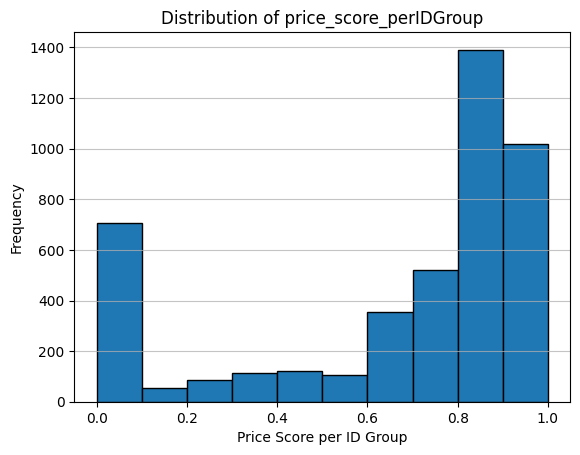

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_reduced is your DataFrame
# Plotting the histogram
df_reduced['price_score_perIDGroup'].plot.hist(bins=10, range=(0, 1), edgecolor='black')

plt.title('Distribution of price_score_perIDGroup')
plt.xlabel('Price Score per ID Group')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)  # Optional: Add grid lines for better readability

plt.show()

** Average indicates that the average maximum relative difference increases with Price**

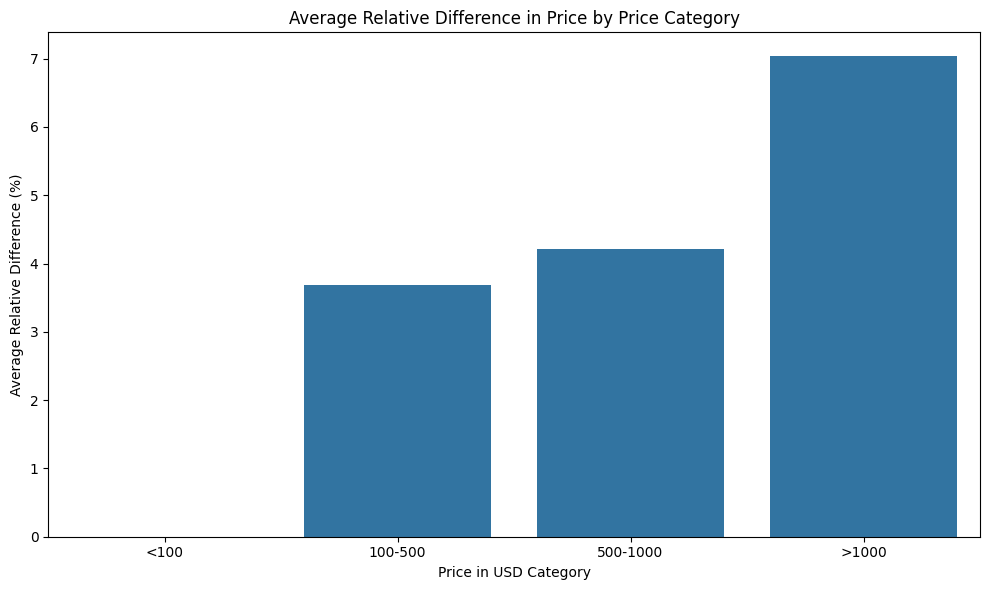

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and labels for 'Price_in_USD'
bins = [0, 100, 500, 1000, float('inf')]
labels = ['<100', '100-500', '500-1000', '>1000']

# Bin 'Price_in_USD' into the defined categories
df_reduced['Price_Category'] = pd.cut(df_reduced['Price_in_USD'], bins=bins, labels=labels)

# Group by the new 'Price_Category' and calculate the mean 'rel_diff' for each category
avg_rel_diff_by_price_cat = df_reduced.groupby('Price_Category', observed=True)['max_rel_diff_perIDGroup'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rel_diff_by_price_cat, x='Price_Category', y='max_rel_diff_perIDGroup')
plt.title('Average Relative Difference in Price by Price Category')
plt.xlabel('Price in USD Category')
plt.ylabel('Average Relative Difference (%)')
plt.tight_layout()
plt.show()


** Median doesnt show this effect **

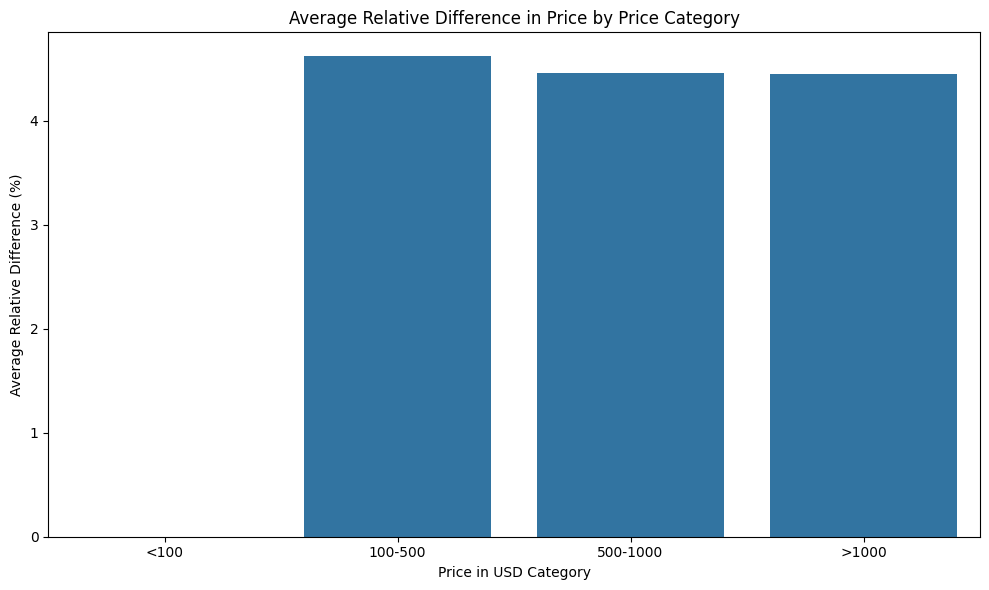

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the bins and labels for 'Price_in_USD'
bins = [0, 100, 500, 1000, float('inf')]
labels = ['<100', '100-500', '500-1000', '>1000']

# Bin 'Price_in_USD' into the defined categories
df_reduced['Price_Category'] = pd.cut(df_reduced['Price_in_USD'], bins=bins, labels=labels)

# Group by the new 'Price_Category' and calculate the mean 'rel_diff' for each category
avg_rel_diff_by_price_cat = df_reduced.groupby('Price_Category', observed=True)['max_rel_diff_perIDGroup'].median().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rel_diff_by_price_cat, x='Price_Category', y='max_rel_diff_perIDGroup')
plt.title('Average Relative Difference in Price by Price Category')
plt.xlabel('Price in USD Category')
plt.ylabel('Average Relative Difference (%)')
plt.tight_layout()
plt.show()

**The average price spread grows with commute time**

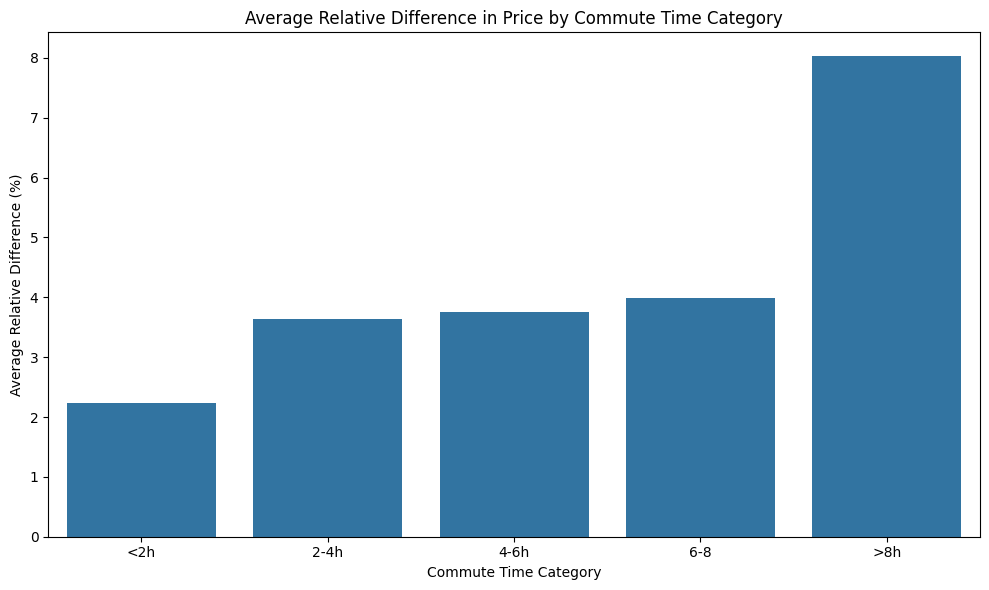

In [58]:
# Adjust bins based on the new categories in minutes
bins = [-float('inf'), 120, 240, 480,750, float('inf')]
labels = ['<2h', '2-4h', '4-6h','6-8' ,'>8h']

# Bin 'commute_time' into categories directly, no need to convert to hours since it's already in minutes
df_reduced['Commute_Time_Category'] = pd.cut(df_reduced['commute_time'], bins=bins, labels=labels)

# Group by the new 'Commute_Time_Category' and calculate the mean 'max_rel_diff_perIDGroup' for each category
avg_rel_diff_by_commute_cat = df_reduced.groupby('Commute_Time_Category', observed = True)['max_rel_diff_perIDGroup'].mean().reset_index()

# Plotting the average relative difference by commute time category
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rel_diff_by_commute_cat, x='Commute_Time_Category', y='max_rel_diff_perIDGroup')
plt.title('Average Relative Difference in Price by Commute Time Category')
plt.xlabel('Commute Time Category')
plt.ylabel('Average Relative Difference (%)')
plt.tight_layout()
plt.show()


**Most Airlines seem to have an average price-spread in between of 3.5 and 4.5**

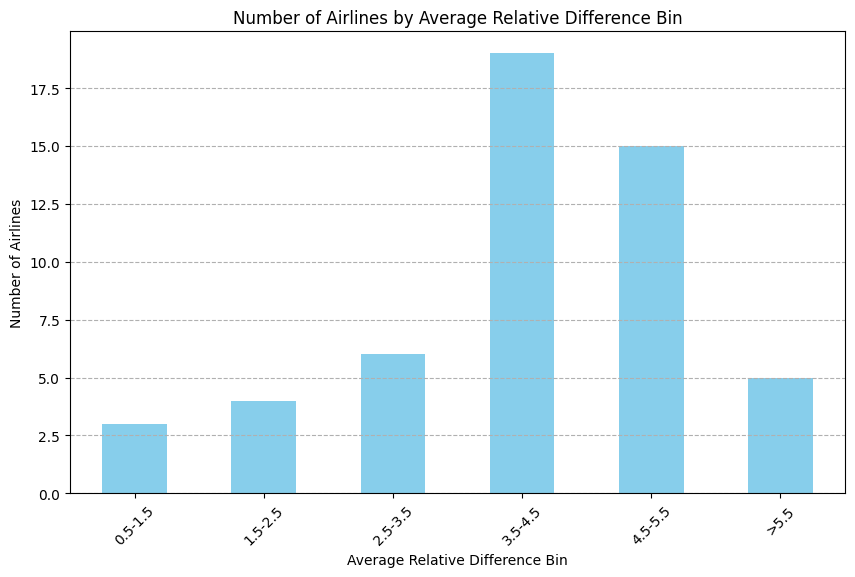

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate the conditional mean of 'rel_diff' for each airline
avg_rel_diff_per_airline = df_reduced.groupby('airline_code', observed=True)['max_rel_diff_perIDGroup'].mean().reset_index()

# Define bins and labels for the categorized means
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, float('inf')]
labels = [ '0.5-1.5', '1.5-2.5', '2.5-3.5', '3.5-4.5', '4.5-5.5', '>5.5']

# Step 2: Categorize these averages into the specified bins
avg_rel_diff_per_airline['avg_rel_diff_bin'] = pd.cut(avg_rel_diff_per_airline['max_rel_diff_perIDGroup'], bins=bins, labels=labels)

# Step 3: Count how many airlines fall into each bin
airlines_per_bin = avg_rel_diff_per_airline['avg_rel_diff_bin'].value_counts().sort_index()

# Plotting the result
airlines_per_bin.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Number of Airlines by Average Relative Difference Bin')
plt.xlabel('Average Relative Difference Bin')
plt.ylabel('Number of Airlines')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()


**Which airlines change their prices based on location**

In [84]:
# Group airlines by their average 'rel_diff' bin
grouped_airlines = avg_rel_diff_per_airline.groupby('avg_rel_diff_bin')['airline_code'].apply(list)

# Convert to a DataFrame for a nicer display, if desired
grouped_airlines_df = grouped_airlines.reset_index().rename(columns={'airline_code': 'Airlines'})
# Adjust display settings
pd.set_option('display.max_columns', 15)  # Show all columns
pd.set_option('display.max_rows', 15)  # Show all rows
pd.set_option('display.max_colwidth', None)  # Show full content of each cell

# Display the DataFrame
print(grouped_airlines_df)


  avg_rel_diff_bin  \
0          0.5-1.5   
1          1.5-2.5   
2          2.5-3.5   
3          3.5-4.5   
4          4.5-5.5   
5             >5.5   

                                                                          Airlines  
0                                                                     [NK, TU, VJ]  
1                                                                 [AS, EI, TG, XE]  
2                                                         [B6, BR, DL, EY, NH, OZ]  
3  [AA, AF, AV, AY, BA, CZ, ET, KE, LA, LH, LO, MS, MU, PC, SQ, TK, TP, WS, multi]  
4                     [AM, AZ, CM, CX, F8, F9, JL, KL, LX, OS, SK, UX, VY, W4, WK]  
5                                                             [AC, EK, IB, QR, UA]  


/var/folders/fs/20409g9545qdjn0qhsrcd8q80000gn/T/ipykernel_16911/3678449169.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_airlines = avg_rel_diff_per_airline.groupby('avg_rel_diff_bin')['airline_code'].apply(list)


In [115]:
avg_rel_diff_per_airline

,airline_code,max_rel_diff_perIDGroup,avg_rel_diff_bin
0,AA,4.355316,3.5-4.5
1,AC,14.731301,>5.5
2,AF,4.239161,3.5-4.5
3,AM,4.637533,4.5-5.5
4,AS,2.468050,1.5-2.5
...,...,...,...
47,W4,4.638016,4.5-5.5
48,WK,4.766589,4.5-5.5
49,WS,4.462403,3.5-4.5
50,XE,1.517413,1.5-2.5


Which countries are the cheapest?

In [99]:
cheap_df = df_reduced[(df_reduced['min'] == df_reduced['Price_in_USD'] )]

# Get the distribution of 'Detected_Country' in the filtered DataFrame
country_distribution = cheap_df['Detected_Country'].value_counts()

# Display the distribution
print(country_distribution)


Detected_Country
Shqipëri          487
Brasil            107
Polska             30
日本                 15
Türkiye            10
United Kingdom      2
Name: count, dtype: int64


**Which countries are more expensive**

In [100]:

expensive_df = df_reduced[(df_reduced['max'] == df_reduced['Price_in_USD'])]

# Get the distribution of 'Detected_Country' in the filtered DataFrame
country_distribution = expensive_df['Detected_Country'].value_counts()

# Display the distribution
print(country_distribution)


Detected_Country
Schweiz               313
Australia             251
Indonesia              53
Vereinigte Staaten     17
Palestine              15
Deutschland             2
United Kingdom          1
Polska                  1
Name: count, dtype: int64


In [119]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'query_date', 'days_until_departure', 'FlightID_in_Countries_Count',
       'whole_Journey', 'max', 'min', 'max_abs_diff_perIDGroup',
       'max_rel_diff_perIDGroup', 'abs_diff_to_min', 'rel_diff_to_min',
       'price_score_perIDGroup', 'Price_Category', 'commute_time',
       'Commute_Time_Category', 'Departure_Time_Category'],
      dtype='object')

In [120]:
from scipy.stats import kruskal
import pandas as pd

# Assuming df_reduced exists and has 'departure_airport_code' and 'rel_diff'

# Group data by 'departure_airport_code' and extract 'rel_diff' values
groups = df_reduced.groupby('departure_airport_code')['max_rel_diff_perIDGroup'].apply(list)

# Perform Kruskal-Wallis H-test
stat, p = kruskal(*groups)

print(f'Statistic: {stat}, P-value: {p}')

# Interpret the results
alpha = 0.05  # Set a significance level
if p < alpha:
    print("Reject the null hypothesis - suggest the median 'rel_diff' differs across departure airports.")
else:
    print("Fail to reject the null hypothesis - no evidence that the median 'rel_diff' differs across departure airports.")


Statistic: 2767.581632591168, P-value: 0.0
Reject the null hypothesis - suggest the median 'rel_diff' differs across departure airports.


# Statistical Testing

In [130]:
from scipy.stats import f_oneway

# Assuming 'flight_data' is your DataFrame containing flight information
# 'Price' is the column containing flight prices, and 'Country' is the column containing country information

# Extract prices for each country
prices_by_country = [group['Price_in_USD'].values for name, group in df_reduced.groupby('Flight_ID')]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*prices_by_country)

# Interpret the results
alpha = 0.05  # Significance level
print("ANOVA results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There are statistically significant differences in mean flight prices among different countries.")
else:
    print("There are no statistically significant differences in mean flight prices among different countries.")


ANOVA results:
F-statistic: 2507.456455184362
p-value: 0.0
There are statistically significant differences in mean flight prices among different countries.


In [133]:
from scipy.stats import f_oneway

# Assuming 'df' is your DataFrame containing flight information
# 'Price_in_USD' is the column containing flight prices, and 'Assigned_Country' is the column containing country information

# Extract prices for each country
prices_by_country = [group['Price_in_USD'].values for name, group in df_reduced.groupby('Flight_ID')]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*prices_by_country)

# Interpret the results
alpha = 0.05  # Significance level
print("ANOVA results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There are statistically significant differences in mean flight prices among different countries for the same flight route.")
else:
    print("There are no statistically significant differences in mean flight prices among different countries for the same flight route.")


ANOVA results:
F-statistic: 2507.456455184362
p-value: 0.0
There are statistically significant differences in mean flight prices among different countries for the same flight route.


In [137]:
from scipy.stats import ttest_rel

# Assuming 'df' is your DataFrame containing flight information
# 'Price_in_USD' is the column containing flight prices, and 'Flight_ID' is the column containing flight identifiers

# Group the data by Flight_ID and calculate the maximum and minimum prices for each group
max_prices = df_reduced.groupby('Flight_ID')['Price_in_USD'].max()
min_prices = df_reduced.groupby('Flight_ID')['Price_in_USD'].min()

# Perform paired samples t-test
t_statistic, p_value = ttest_rel(max_prices, min_prices)

# Interpret the results
alpha = 0.05  # Significance level
print("Paired samples t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There is a statistically significant difference between the maximum and minimum prices of each Flight_ID.")
else:
    print("There is no statistically significant difference between the maximum and minimum prices of each Flight_ID.")


Paired samples t-test results:
t-statistic: 8.469501196061369
p-value: 1.641996215865534e-16
There is a statistically significant difference between the maximum and minimum prices of each Flight_ID.


In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['Flight_ID'], df['Assigned_Country'])

# Perform chi-square test of independence
chi2_statistic, p_value, _, _ = chi2_contingency(contingency_table)

# Interpret the results
alpha = 0.05  # Significance level
print("Chi-square test results:")
print("Chi-square statistic:", chi2_statistic)
print("p-value:", p_value)

if p_value < alpha:
    print("There is a significant association between Flight_ID and Assigned_Country.")
else:
    print("There is no significant association between Flight_ID and Assigned_Country.")


In [179]:
df_reduced.columns

Index(['airline_code', 'departure_airport_code', 'destination_airport_code',
       'ticket_price', 'departure_date', 'arrival_date', 'First_flight',
       'first_flight_code', 'last_flight_code', 'Detected_Language',
       'Detected_Country', 'Detected_Currency', 'Flight_ID', 'Price_in_USD',
       'query_date', 'days_until_departure', 'FlightID_in_Countries_Count',
       'whole_Journey', 'max', 'min', 'max_abs_diff_perIDGroup',
       'max_rel_diff_perIDGroup', 'abs_diff_to_min', 'rel_diff_to_min',
       'price_score_perIDGroup', 'Price_Category', 'commute_time',
       'Commute_Time_Category', 'Departure_Time_Category',
       'Cheapest_Location'],
      dtype='object')

In [187]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



# Define independent and dependent variables
X = pd.get_dummies(df_reduced[['whole_Journey']], drop_first=True)
y = pd.get_dummies(df_reduced['Cheapest_Location'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=41)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(f"R² score: {r2_score(y_test, y_pred)}")
print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")


R² score: 0.6239321523923724
Mean squared error: 0.012524083117376144


In [ ]:
# Extract the model intercept
intercept = model.intercept_

# Extract the model coefficients
coefficients = model.coef_

# Get the feature names after one-hot encoding
feature_names = X_train.columns

# Constructing the regression equation as a string
regression_equation = f"y = {intercept:.2f}"
for coef, name in zip(coefficients, feature_names):
    regression_equation += f" + ({coef:.2f})*{name}"

print("Regression Equation:")
print(regression_equation)


In [ ]:
coefficients_series = pd.Series(model.coef_, index=X_train.columns)


In [ ]:
coefficients_series.count()

In [ ]:
abs(coefficients_series ) > 0

In [ ]:
significant_coefficients = coefficients_series[abs(coefficients_series) > 5]


In [ ]:
significant_coefficients.count()

In [ ]:
df_reduced.max_rel_diff_perIDGroup.value_counts()

In [ ]:
df_reduced.columns

In [ ]:
# Calculate the mean of max_rel_diff_perIDGroup for each Flight_ID
grouped_means = df_reduced.groupby('FlightID_in_Countries_Count')['max_rel_diff_perIDGroup'].mean()

In [ ]:
df_reduced.FlightID_in_Countries_Count.value_counts()

In [ ]:
df_reduced.max_rel_diff_perIDGroup.max()

In [ ]:
df_reduced.Price_in_USD.value_counts()

In [ ]:
df_reduced.iloc[139:142]

In [ ]:
df_reduced.FlightID_in_Countries_Count.value_counts()

In [ ]:
grouped_means

In [ ]:
# Calculate the mean of max_rel_diff_perIDGroup for each Flight_ID
grouped_means = df_reduced.groupby('airline_code')['max_rel_diff_perIDGroup'].mean()


In [ ]:
grouped_means.count()

In [ ]:
grouped_means.sort_values(ascending=False)

In [ ]:
grouped_means.head()

In [ ]:
df_reduced.max_rel_diff_perIDGroup.median()

In [ ]:
import matplotlib.pyplot as plt

# Plotting the histogram of the aggregated means
plt.hist(grouped_means, bins=10, range=(0, 10), edgecolor='black')
plt.title('Distribution of Average max_rel_diff_perIDGroup per Flight_ID')
plt.xlabel('Average max_rel_diff_perIDGroup')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting directly from the DataFrame
df_reduced['max_rel_diff_perIDGroup'].hist(bins=10, range=(0, 10))

plt.title('Distribution of max_rel_diff_perIDGroup')
plt.xlabel('max_rel_diff_perIDGroup')
plt.ylabel('Frequency')
plt.grid(False)  # Optionally disable the grid for a cleaner look
plt.show()


In [ ]:
from scipy.stats import ttest_1samp
import numpy as np

# Assuming df_reduced is your DataFrame and max_rel_diff_perIDGroup is the column you're testing
data = df_reduced['max_rel_diff_perIDGroup'].dropna()  # Drop NaN values if any

# Perform the one-sample t-test against the null hypothesis that the mean is 0
t_statistic, p_value = ttest_1samp(data, 0)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("We reject the null hypothesis. The mean of max_rel_diff_perIDGroup is significantly different from 0.")
else:
    print("We fail to reject the null hypothesis. There is not enough evidence to say the mean of max_rel_diff_perIDGroup is significantly different from 0.")


In [ ]:
top_20_significant = significant_coefficients.abs().sort_values(ascending=False).head(20)
# To get the original coefficients (with their signs) in the order of significance:
top_20_significant = significant_coefficients.loc[top_20_significant.index]

In [ ]:
top_20_significant

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assuming df_reduced is your DataFrame and it's already loaded

# Prepare your data: Get dummies for categorical variables
X = pd.get_dummies(df_reduced[['airline_code', 'Price_in_USD', 'Assigned_Country', 'First_flight']], drop_first=True)
y = df_reduced['max_rel_diff_perIDGroup']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Lasso regression model
# alpha is the regularization strength; larger values specify stronger regularization.
lasso_model = Lasso(alpha=0.1)  # You might need to adjust the alpha value

# Fit the Lasso model to the training data
lasso_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = lasso_model.predict(X_test)

# Evaluate the model
print(f"R² score: {r2_score(y_test, y_pred)}")
print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")

# Viewing the coefficients
coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)
print("Coefficients:")
print(coefficients)
